In [1]:
import json
import os
import boto3
from PIL import Image
import io
import base64
from langchain_aws import ChatBedrock
from langchain_core.prompts import ChatPromptTemplate

bedrock = boto3.client(service_name='bedrock-runtime', region_name="us-east-1")

inference_modifier = {
    "max_tokens": 4096,
    "temperature": 1,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"],
}

In [2]:
# MODEL SELECTION
#modelId = "anthropic.claude-3-haiku-20240307-v1:0"
#modelId = "anthropic.claude-3-5-sonnet-20240620-v1:0"
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"

In [3]:
model = ChatBedrock(
    model_id=modelId,
    client=bedrock,
    model_kwargs=inference_modifier,
    streaming=True,
)

In [4]:
system_prompt = """
Você é um especialista em criar drinks sem álcool (mocktails) de 300 ml. 
Na tag XML <ingredients></ingredients> você vai encontrar a lista de ingredientes 
que tem à sua disposição para a elaboração dos drinks.

<ingredients>
* Gelo
* Líquidos (opções: água, água com gás, cajuína)
* Adoçante (opções: açúcar, adoçante)
* Frutas (opções: morango, kiwi, abacaxi, melão, tomate, pera, maçã, uva, limão) - Pode escolher mais de uma opção.
* Folhas (opções: hortelã, folha de louro, rúcula, salsinha) - Pode escolher mais de uma opção.
* Xaropes (opções: morango, kiwi, blueberry)
</ingredients>

Na tag XML <general_instructions></general_instructions> você vai encontrar algumas guidelines gerais para executar suas tarefas.

<general_instructions>
1. Nunca invente um nome para a pessoa. Utilize EXATAMENTE o nome que foi passado.
2. Nunca use um ingrediente que não está na lista. Pense cuidadosamente sobre isso.
3. Nunca vincule o estado de espírito ao nome da pessoa. 
Use o estado de espírito apenas para determinar a receita.
4. No final da receita, adicione uma frase motivacional, relacionada ao estado de espírito da pessoa. 
Torne esta frase algo único e memorável.
</general_instructions>
"""

#Você é um assistente amigável de IA generativa que ajuda seus usuários a construírem receitas inovadoras 
#de drinks não alcólicos.

In [5]:
my_prompt = """
<instructions>
<step1>
Avalie cuidadosamente se o input do usuário possui qualquer tipo de conteúdo ofensivo, 
impróprio, de baixo calão ou chulo, mesmo que escrito em grafias diferentes. 
Se possuir, responda com um texto educado dizendo que a receita não foi gerada porque 
o nome parece ferir o código de conduta desta aplicação.
</step1>
<step2>
Verifique se as informações necessárias estão disponíveis no prompt. As informações necessárias são:

* Nome do usuário
* Seu estado de espírito (como a pessoa está se sentindo hoje)
* os ingredientes necessários para a elaboração do drink

Se algum ingrediente ou alguma informação estiver faltando de acordo com os seus registros, 
responda o usuário dizendo qual informação está faltando para que você consiga elaborar o drink.
</step2>
<step3>
Pense cuidadosamente sobre as atividades que você vai desempenhar. 
Escreva essas atividades dentro de uma tag <thinking></thinking>
</step3>
<step4>
Escreva o nome do drink criado, sua receita e modo de preparo de acordo com o 
template dentro da tag XML <output_format></output_format>
O nome do drink deve ser memorável, engajante e, se seu estado de espírito for 
negativo, motivacional para um estado de espírito mais positivo.
</step4>
<step5>
Escreva uma frase motivacional em itálico levando em conta o nome do usuário, 
seu estado de espírito, o nome do drink e os ingredientes escolhidos.
</step5>
</instructions>

<output_format>
**NOME DO DRINK**

Ingredientes:

* Gelo
* Líquido escolhido
* Adoçante escolhido
* Frutas escolhidas
* Folhas escolhidas
* Xarope escolhido


Modo de preparo:

* Instruções detalhadas de como preparar o drink.

*Conteúdo da frase motivacional*
</output_format>

Na tag XML <user_input></user_input> você vai encontrar o input do usuário.
<user_input>
{}
</user_input>

Faça um resumo das tarefas que deve executar.

Assistant:
<instructions_structure>
1. Verificar se o nome do usuário não possui conteúdo ofensivo, impróprio, de baixo calão ou chulo.
2. Verificar se todas as informações necessárias estão disponíveis no prompt, incluindo o nome do usuário, seu estado de espírito e os ingredientes necessários.
3. Pensar cuidadosamente sobre as atividades que serão desempenhadas para criar o drink sem álcool (mocktail).
4. Escrever o nome do drink criado, sua receita e modo de preparo de acordo com o template.
5. Escrever uma frase motivacional em itálico, levando em conta o nome do usuário, seu estado de espírito, o nome do drink e os ingredientes escolhidos.
</instructions_structure>

Human: Está correto. 
A resposta deve ser em PT-BR.
Por favor, execute a tarefa.
"""

In [7]:
input_do_usuario = """
Olá. Tudo bem? Eu sou Gabriel e estou me sentindo cansado.
"""

In [8]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt,),
        ("human", "{input}"),
    ]
)

chain = prompt | model

for chunk in chain.stream(
    {"input": my_prompt.format(input_do_usuario)},
):
    print(chunk.content, end="", flush=True)

Vou executar as tarefas conforme solicitado:

<thinking>
1. Verificar se o nome "Gabriel" não possui conteúdo ofensivo ou impróprio - o nome parece apropriado.

2. Verificar se todas as informações necessárias estão disponíveis:
   - Nome do usuário: Gabriel (disponível)
   - Estado de espírito: cansado (disponível)
   - Ingredientes: a lista de ingredientes está disponível nas tags XML

3. Pensar sobre as atividades a serem desempenhadas:
   - Escolher ingredientes adequados para um drink revigorante e energizante 
   - Criar uma receita fácil de preparar
   - Dar um nome memorável e motivacional ao drink
   - Escrever uma frase inspiradora relacionada ao estado de cansaço

4. Escrever o nome do drink, receita e modo de preparo conforme o template especificado.

5. Escrever uma frase motivacional em itálico, considerando o nome, estado de espírito e ingredientes escolhidos.
</thinking>

<output_format>
**Reviver Cítrico** 

Ingredientes:

* Gelo
* Água com gás
* Açúcar 
* Laranja, lim

In [9]:
image_prompt = """
Você é um especialista em representar receitas de drinks através de imagens vibrantes e cativantes. 
Dada a receita de drink abaixo, crie uma imagem no estilo realista que possa representar o drink da melhor forma possível:

**Raiocitrus Energizante**

Ingredientes:

* Gelo
* Água com gás
* Açúcar 
* Limão, laranja, kiwi
* Hortelã, rúcula
* Xarope de morango

Modo de preparo:

* Descasque e corte as frutas em pedaços.
* Amasse levemente as folhas para liberar os aromas.
* Em um liquidificador, bata as frutas, folhas, gelo, água com gás, açúcar e xarope até obter uma mistura homogênea.
* Coe a mistura para remover cascas e folhas.
* Decore com rodelas de laranja e folhas de hortelã.

*Assim como um raio ilumina o céu, que este Raiocitrus Energizante traga luz e energia renovada para você, Gabriel! Beba devagar e sinta a vitalidade percorrendo seu corpo.*

Não represente pessoas. Apenas o desenho do drink no local/ambiente em que ele vai ser servido.
"""


negative_prompts = [
    "letras ou texto"
]
style_preset = "photographic"
clip_guidance_preset = "NONE"
width = 512

request = json.dumps({
    "text_prompts": (
        [{"text": image_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "seed": 2531586414,
    "steps": 60,
    "style_preset": style_preset,
    #"clip_guidance_preset": clip_guidance_preset,
    #"sampler": sampler,
    "width": width,
})
imageModelId = "stability.stable-diffusion-xl-v1"

response = bedrock.invoke_model(body=request, modelId=imageModelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAQACAIAAAAYynaXAAANsmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


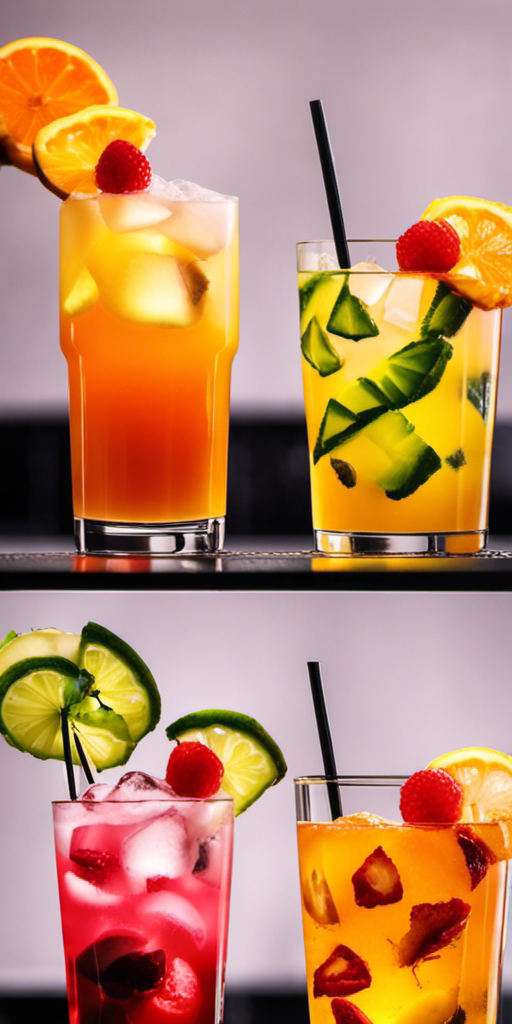

In [10]:
os.makedirs("image", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("image/image_1.png")
image_1